In [1]:

import pandas as pd
import numpy as np

In [61]:
data_full=pd.read_csv("../raw_data/trainset_full.csv")
data_miss=pd.read_csv("../raw_data/trainset.csv")

In [3]:
data_miss

,index,turbine_id,measured_at,wind_speed,power,nacelle_direction,wind_direction,rotor_speed,generator_speed,temp_environment,temp_hydraulic_oil,temp_gear_bearing,cosphi,blade_angle_avg,hydraulic_pressure,park_id,error_category
0,0,11,2020-01-01 00:00:00+00:00,0.433333,0.121250,266.0,266.3,0.677852,0.569444,5.0,20.0,32.0,0.85,-1.9,189.2,1,NO_ERROR
1,1,11,2020-01-01 00:10:00+00:00,0.458333,0.138750,266.6,267.0,0.704698,0.591766,5.0,20.0,33.0,0.88,NaN,189.5,1,NO_ERROR
2,2,11,2020-01-01 00:20:00+00:00,0.508333,0.182950,270.7,269.4,0.771812,0.647321,5.0,20.0,34.0,0.92,-2.0,190.1,1,NO_ERROR
3,3,11,2020-01-01 00:30:00+00:00,0.525000,0.218100,272.1,272.7,0.805369,0.676091,5.0,20.0,38.0,0.94,-2.0,190.0,1,NO_ERROR
4,4,11,2020-01-01 00:40:00+00:00,0.541667,0.234300,279.5,281.1,0.832215,0.700397,5.0,20.0,41.0,0.95,-2.0,189.9,1,NO_ERROR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367185,1367185,29,2021-04-30 22:10:00+00:00,0.253846,0.004242,64.9,65.9,0.525000,0.468333,12.0,42.0,53.0,0.60,-1.7,247.2,2,NO_ERROR
1367186,1367186,29,2021-04-30 22:20:00+00:00,0.261538,0.007152,64.9,68.5,0.525000,0.466733,11.0,42.0,53.0,0.90,-1.8,246.8,2,NO_ERROR
1367187,1367187,29,2021-04-30 22:30:00+00:00,0.261538,0.007970,64.9,65.2,0.525000,0.466733,11.0,43.0,54.0,0.90,-1.7,247.0,2,NO_ERROR
1367188,1367188,29,2021-04-30 22:40:00+00:00,0.307692,0.030394,64.9,62.1,0.525000,0.468933,11.0,43.0,55.0,1.00,-2.5,246.9,2,NO_ERROR


Missing data given as NaN

Missing values are only present for wind_speed, power, rotor_speed, generator_speed, temp_environment, temp_hydraulic_oil, temp_gear_bearing, blade_angle_avg

In [13]:
n_miss = np.sum(np.asarray(data_miss.isna()), axis=0)
keys_miss = data_miss.keys()
comb = list(zip(keys_miss, n_miss))
print(comb)

[('index', 0), ('turbine_id', 0), ('measured_at', 0), ('wind_speed', 101176), ('power', 58136), ('nacelle_direction', 0), ('wind_direction', 0), ('rotor_speed', 96922), ('generator_speed', 98536), ('temp_environment', 71404), ('temp_hydraulic_oil', 71558), ('temp_gear_bearing', 70575), ('cosphi', 0), ('blade_angle_avg', 187489), ('hydraulic_pressure', 0), ('park_id', 0), ('error_category', 0)]


(array([4.26325e+05, 9.55850e+04, 3.11390e+04, 1.07220e+04, 9.20000e+01,
        7.00000e+00]),
 array([0.5       , 1.66666667, 2.83333333, 4.        , 5.16666667,
        6.33333333, 7.5       ]),
 <BarContainer object of 6 artists>)

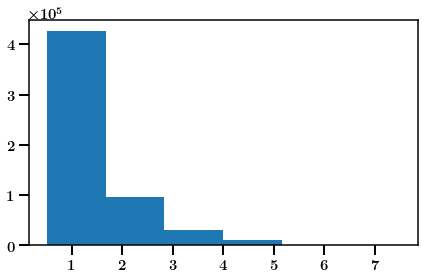

In [10]:
import matplotlib.pyplot as plt
plt.hist(np.sum(np.asarray(data_miss.isna()), axis=1), bins=np.linspace(0.5, 7.5, 7))

# 1st Try with kNN

Implement kNN for each individual turbine. Distance is given by time and target by the 8 possible missing values

In [67]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import Normalizer

In [62]:
# convert to minute time stamp
data_full["date"] = pd.to_datetime(data_full["measured_at"]).view(int)/ 10**9 / 60. # in minutes
min_min = np.min(data_full["date"])
data_full["date"] = data_full["date"] - min_min

In [63]:
for ns in range(2, 10):
    # optimize n neighbors
    neigh = KNeighborsRegressor(n_neighbors=ns)

    ids = np.where(data_full['turbine_id'] == 11)[0]
    data_train = data_full.loc[ids]
    X = np.asarray(data_train['date']).reshape(-1, 1)
    Y = np.asarray(data_train[['wind_speed', 'power', 'rotor_speed', 'generator_speed', 'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'blade_angle_avg']])
    transformer = Normalizer().fit(Y)
    neigh.fit(X, Y)
    err = np.mean(np.power((Y - neigh.predict(X)), 2.), axis=0)
    std = np.std(Y, axis=0)
    print(f"{ns} , {err / std * 100}")

2 , [ 0.32298226  0.41628696  0.57768842  0.46823189  0.43109079  0.39876696
  1.97833793 42.22562096]
3 , [ 0.32234676  0.40322656  0.52381125  0.42365308  0.43044259  0.30987708
  0.98395584 36.14900282]
4 , [ 0.50020399  0.64680598  0.88146382  0.71483018  0.65544514  0.57101031
  2.63800674 62.90493162]
5 , [ 0.55898093  0.73122959  1.01042552  0.81945824  0.70014707  0.55451756
  2.22429555 73.45010408]
6 , [ 0.68877966  0.91062487  1.27241593  1.03336712  0.86573886  0.79216871
  3.9309524  94.76080238]
7 , [  0.74954155   0.99746114   1.39408093   1.13301603   0.91454912
   0.8131208    3.98259647 106.08078563]
8 , [  0.85383645   1.14154126   1.60943692   1.30839626   1.05430154
   1.04469773   5.85165621 123.42901924]
9 , [  0.91300359   1.2255983    1.72750526   1.40490557   1.10099254
   1.08960846   6.33055851 134.49334243]


kNN is pretty good as a first guess except for blade_angle_avg and maybe temp_gear_bearing

n_neighbours=3 performs best

so far only using data from previous values.

How to use correlation with other values? / Other turbines in the windpark?

For environmental variables: temp_environment and wind_speed

## 2. Try use data from all turbines in the windpark to build kNN

In [66]:
for ns in range(2, 10):
    # optimize n neighbors
    neigh = KNeighborsRegressor(n_neighbors=ns)

    ids = np.where(data_full['park_id'] == 1)[0]
    data_train = data_full.loc[ids]
    X = np.asarray(data_train['date']).reshape(-1, 1)
    Y = np.asarray(data_train[['wind_speed', 'power', 'rotor_speed', 'generator_speed', 'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'blade_angle_avg']])
    neigh.fit(X, Y)

    # validation
    ids = np.where(data_full['turbine_id'] == 11)[0]
    data_test = data_full.loc[ids]
    X = np.asarray(data_test['date']).reshape(-1, 1)
    Y = np.asarray(data_test[['wind_speed', 'power', 'rotor_speed', 'generator_speed', 'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'blade_angle_avg']])
    err = np.mean(np.power((Y - neigh.predict(X)), 2.), axis=0)
    std = np.std(Y, axis=0)
    print(f"{ns} , {err / std * 100}")

2 , [  0.94606986   1.51149852   3.02872634   2.53667886   1.55887133
 102.83475339 202.43658442 614.93047312]
3 , [  0.80460524   1.27717112   2.58846231   2.1651768    1.44556694
  90.33222051 165.76702773 535.15627948]
4 , [  0.75304372   1.20276594   2.42506303   2.02633471   1.44144961
  76.83678065 146.51049307 501.79109464]
5 , [  0.81671953   1.30002973   2.61224974   2.18199515   1.50828478
  81.845068   154.60382053 534.29315251]
6 , [  0.85822918   1.35500489   2.6826639    2.23891538   1.52536227
  80.82461606 153.97896499 537.06514103]
7 , [  0.89454601   1.39144499   2.67906435   2.23429162   1.53534774
  79.31395226 150.89287872 527.23534738]
8 , [  0.91877191   1.42406888   2.696243     2.2475341    1.55683826
  77.89737786 148.13056923 523.14954057]
9 , [  0.90220869   1.39575041   2.64085168   2.20119491   1.53611365
  75.92493383 145.35107743 511.00381298]


Fail, that is much worse than before